# Urban Observatory Image Processing
The Urban Observatory has a ton of images and we needed a streamlined way of accessing and processing them efficiently. So we developed a few classes to help us do that.

It's as easy as:
```python
# plot the images
for im in imdb.load_images(srcs).bgsub2():
    plt.imshow(im)
    plt.show()

# or create a gif
pipeline = imdb.load_images(srcs).bgsub2().save_gif('my-gif')
Image(url=pipeline())
```

This covers:
* loading original images
* loading images concurrently
* loading background subtraction images
* exporting gifs
* exporting images
* drawing ground truth boxes
* drawing detections
* building pipelines
* adding custom pipeline functions
* notes on customizing/extending uoimdb

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import uoimdb as uo
import dataset as ds
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
plt.rcParams['figure.figsize'] = 15, 8 # matplotlib figures are too damn small

## The UO Image Database (uoimdb)
This is the main class that you deal with to process images. It is a wrapper around a Pandas dataframe (accessible via `self.df`) containing a list of all image paths and their datetimes. This is also where image data is cached when in use to minimize disk I/O. 

> **Warning**: The first run of the class will take approximately 30 mins because it needs to extract around 1 million timestamps from files. After this, the entire dataframe is saved to file so that it doesn't need to be computed again and subsequent calls will only take a few seconds to load. If you have access to `/gscratch/share/plumes_capstone` you can find and copy the cached file at `github/images_df.pkl`.

In [4]:
imdb = uo.uoimdb()
print(imdb.df.shape)
imdb.df.head()

(1133810, 3)


date   im  \
src                                                                           
2013/10/28/13.48.16/oct08_2013-10-25-175504-607... 2013-10-26 10:50:54  NaN   
2013/10/26/10.51.04/oct08_2013-10-25-175504-607... 2013-10-26 10:51:04  NaN   
2013/10/26/10.51.04/oct08_2013-10-25-175504-607... 2013-10-26 10:51:14  NaN   
2013/10/26/10.51.04/oct08_2013-10-25-175504-607... 2013-10-26 10:51:24  NaN   
2013/10/26/10.51.04/oct08_2013-10-25-175504-607... 2013-10-26 10:51:34  NaN   

                                                                                                  idx  
src                                                                                                    
2013/10/28/13.48.16/oct08_2013-10-25-175504-607...  2013,10,28,13.48.16,oct08_2013-10-25-175504-60...  
2013/10/26/10.51.04/oct08_2013-10-25-175504-607...  2013,10,26,10.51.04,oct08_2013-10-25-175504-60...  
2013/10/26/10.51.04/oct08_2013-10-25-175504-607...  2013,10,26,10.51.04,oct08_2013-10-25-175504-60...  
2013/10/26/10.51.04/oct08_2013-10-25-175504-607...  2013,10,26,10.51.04,oct08_2013-10-25-175504-60...  
2013/10/26/10.51.04/oct08_2013-10-25-175504-607...  2013,10,26,10.51.04,oct08_2013-10-25-175504-60...

When printing `df.head()`, you should see a dataframe indexed by the relative path of the images (relative to the common image path for all files) and sorted by `date`. There is an empty column called `im` which is used to store the cached image data. The column `idx` represents the filename that is used to save derived image files (e.g. background subtracted) to disk (basically, I just replaced all `/` with `,` in the src).

## Building image pipelines

Pipelines are created out of the imdb object and consist of chained generator/functions that get called across all images.

### Original images

To show the original images, do: 

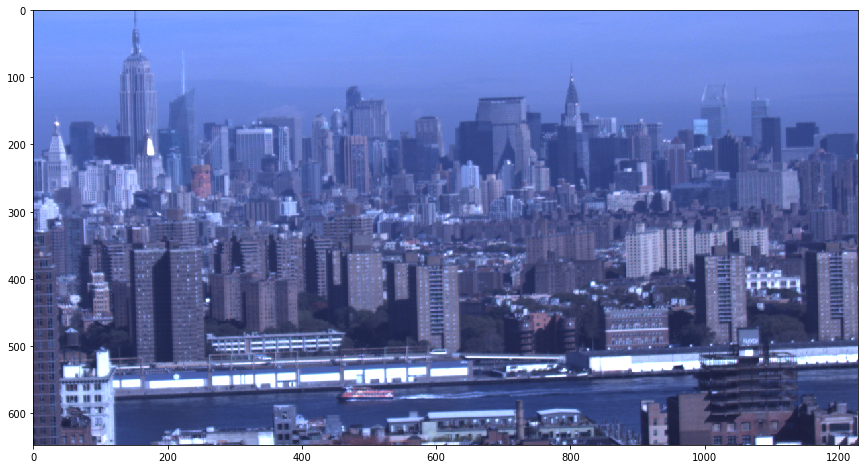

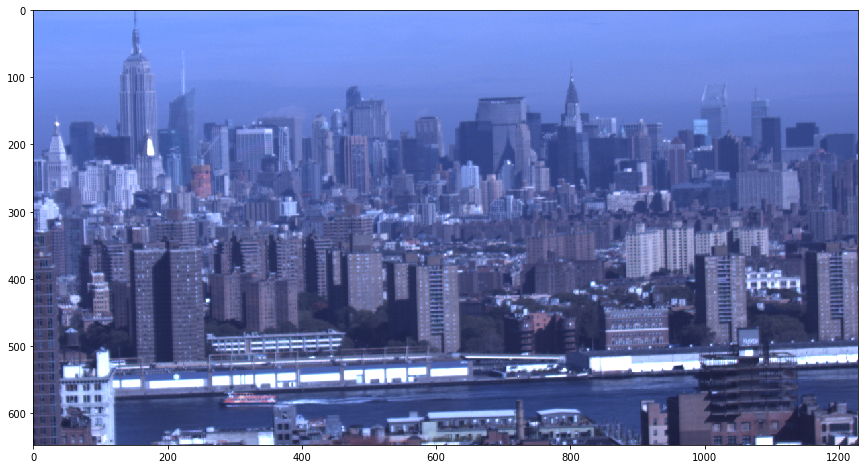

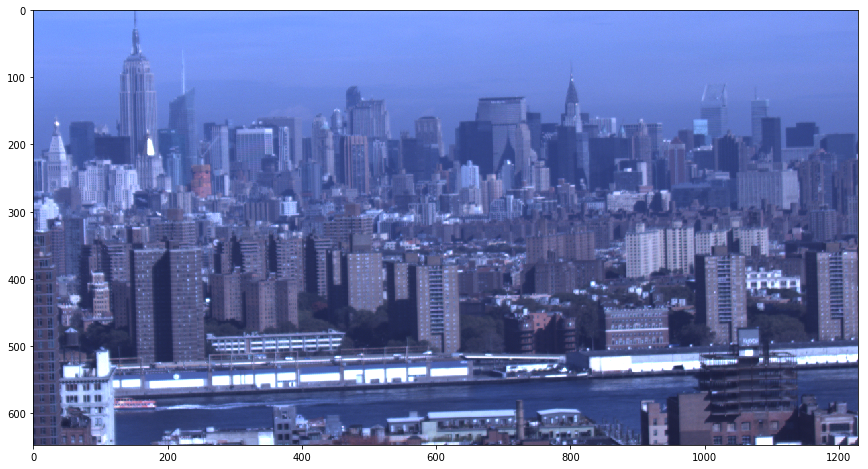

In [5]:
srcs = imdb.df.index[:3]
pipeline = imdb.load_images(srcs)
for img in pipeline:
    plt.imshow(img)
    plt.show()

You can load images in parallel using a multiprocessing.Pool by passing a pool parameter to load_images. The easiest way is to just use `imdb.load_images(srcs, pool=True)` which will open a pool with `min(len(srcs), imdb.max_processes)` processes. If you want to specify the number of processes of the pool manually, just pass an integer instead `imdb.load_images(srcs, pool=5)`. If you want maximum control, you can pass an existing pool object. If you do so, it is assumed that you are using a `with` statement:
```python
with mp.Pool(5) as pool:
    pipeline = imdb.load_images(srcs, pool=pool)
    for img in pipeline:
        plt.imshow(img)
        plt.show()
```
If you want to pass it inline, you need to specify `close=True` in order to prevent zombie processes.
```python
pipeline = imdb.load_images(srcs, pool=mp.Pool(5), close=True)
for img in pipeline:
    plt.imshow(img)
    plt.show()
```

Obviously doing this for 3 images isn't going to speed it up (it'll slow it down), but when you're loading 100's or 1000's of images, it definitely helps.

3 images total. 3 missing. 3 workers. 64 cpus total.


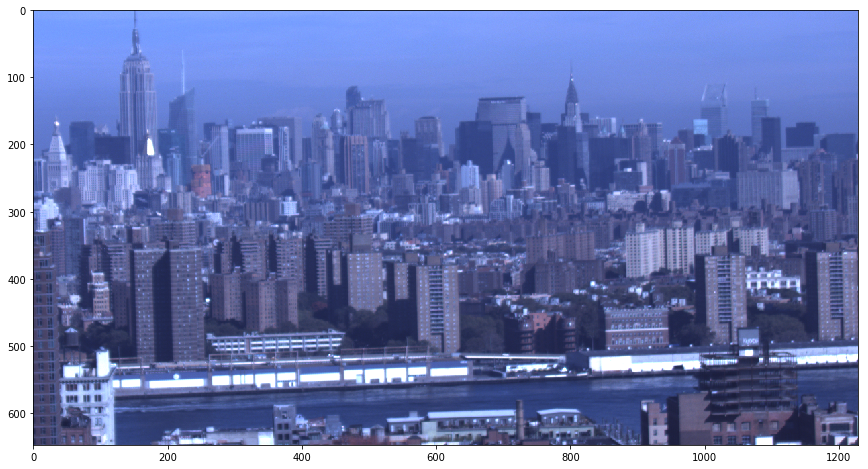

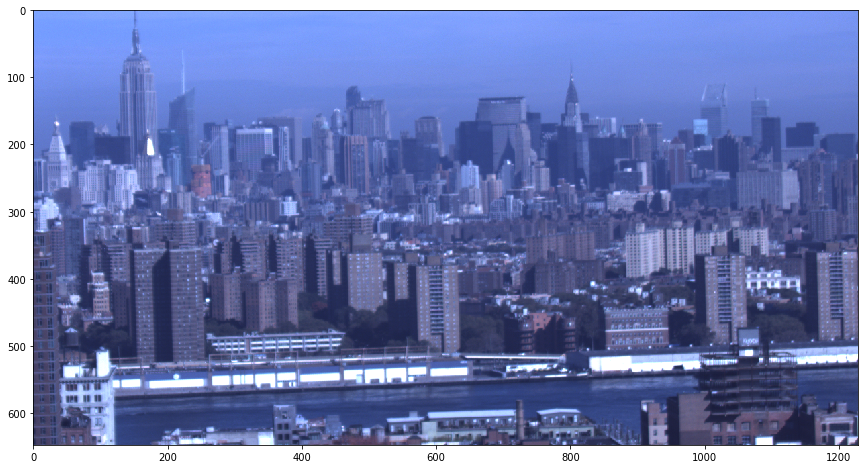

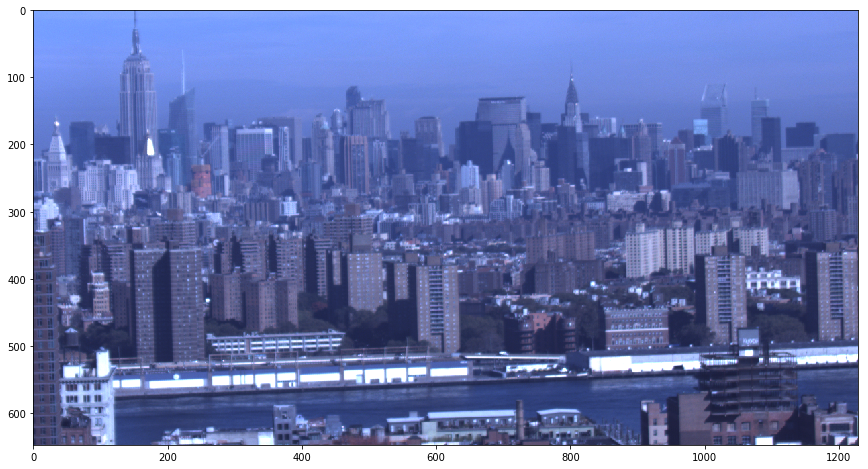

In [6]:
srcs = imdb.df.index[3:6]
pipeline = imdb.load_images(srcs, pool=True)
for img in pipeline:
    plt.imshow(img)
    plt.show()

By default, `load_images` converts the images from BGR to RGB and resizes them to 0.3x their original size for faster computations. To get the raw (full-size, BGR) images, do: 

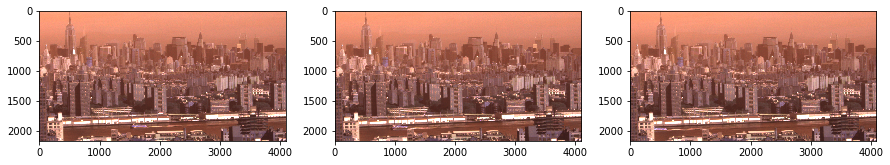

In [7]:
srcs = imdb.df.index[:3]
pipeline = imdb.load_images(srcs, raw=True)
for i, img in enumerate(pipeline, 1):
    plt.subplot(1, 3, i)
    plt.imshow(img)

### Background subtraction

Most background subtraction that we're doing is done on consecutive images. So we use an optimization to reduce the amount of array operations that need to be performed. So instead of computing the mean across all background images, we just subtract out the oldest image and then add in the new image. The edge cases are handled using sticky windows. So for background subtraction with a window size of n, the first n/2 images and the last n/2 images will use the same set of background images, respectively. 

To get background subtracted images using this assumption, do: 

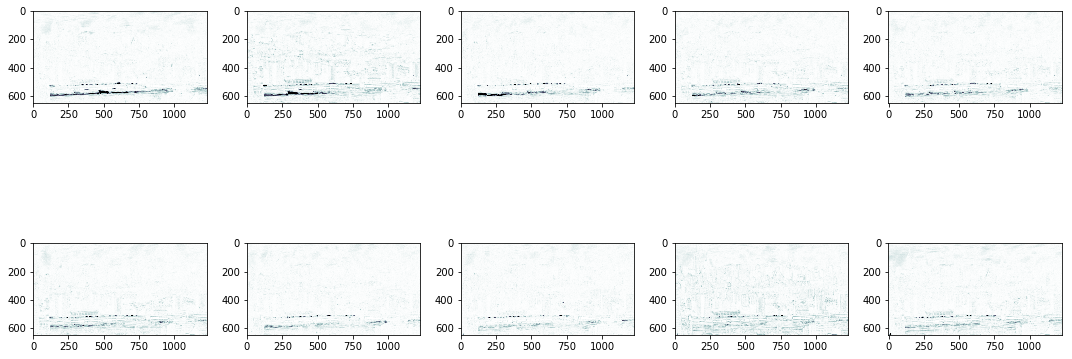

In [8]:
srcs = imdb.df.index[:10]
pipeline = imdb.load_images(srcs).bgsub2()

for i, img in enumerate(pipeline, 1):
    plt.subplot(2, 5, i)
    plt.imshow(img)
plt.tight_layout()

Using `.bgsub2()` is equivalent to calling: 
```python
(pipeline.grey()
         .blur()
         .bgsub()
         .blur()
         .scale()
         .clip()
         .invert()
         .cmap('bone')
         .astype('uint8'))
```

Sometimes we don't need background subtraction across a set of images and we just need it for one image.
To get the background subtraction for a specific image (using 7 images before and 5 after as an example), do:

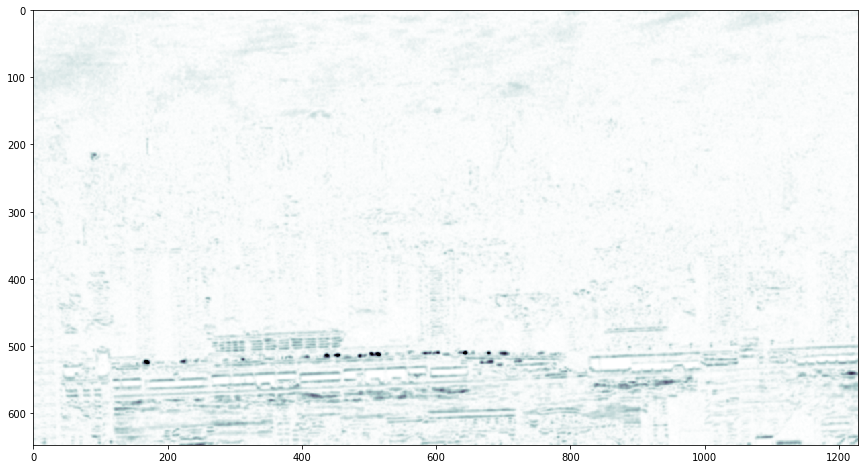

In [9]:
src = imdb.df.index[10]
pipeline = imdb.load_around(src, window=(7,5)).single_bgsub2()
plt.imshow(pipeline.first())

### Exporting

#### Gif
If you want to create a gif from the images, use `.save_gif()`. This pipe returns the path to the gif that was saved. So to save and view the gif, just do: 

In [10]:
from IPython.display import Image
srcs = imdb.df.index[:10]
pipeline = (imdb.load_images(srcs)
                .crop()
                .bgsub2()
                .save_gif('my-fancy-gif-name'))
Image(url=pipeline())

**Note:** The timestamp is appended to the filename as a query string to prevent image caching.

#### Images
To save each image individually, use `.save_images()`. This pipe returns an iterable of the paths to the files that were saved. So to save and view the images, just do: 

In [11]:
from IPython.display import display, Image
srcs = imdb.df.index[:3]
pipeline = (imdb.load_images(srcs)
                .crop()
                .rgb2bgr() # opencv saves with bgr
                .save_images('my-output-directory'))
for path in pipeline:
    display(Image(url=path))

### Drawing bounding boxes

The dataset class is meant to abstract away the loading of the exported dataset as well as the outputted model detections. The datasets are found under `./Data`.

In [12]:
import dataset as ds

In [13]:
dataset = ds.VOCDataset('UOImages-full')
dataset

<VOCDataset: UOImages-full. 5789 images (409x1229x3). 
        classes: ['__background__', 'plume', 'shadow', 'cloud', 'light', 'ambiguous']>

In [14]:
gt_df = dataset.get_ground_truth('plumes-clean.csv')
print(gt_df.shape)
gt_df.head()

(16554, 19)


id  \
idx                                                                                    
2015,02,08,09.56.04,temp__2015-01-14-162059-213...  00038992f65fdf4e931da4edd5fcbe37   
2015,02,08,09.31.00,temp__2015-01-14-162059-213...  0012e77658ce8733043ede8b558eb38c   
2013,12,04,07.12.45,oct08_2013-10-25-175504-341...  0017a5362437680e39adcf83ed16acad   
2013,12,04,07.47.46,oct08_2013-10-25-175504-342...  001c96c8b5ef6f2dc3990619cfd2915c   
2015,02,08,07.35.53,temp__2015-01-14-162059-212...  001eb79a976caaa2324b66b427db4392   

                                                           h  label  \
idx                                                                   
2015,02,08,09.56.04,temp__2015-01-14-162059-213...  0.063582  plume   
2015,02,08,09.31.00,temp__2015-01-14-162059-213...  0.339270  plume   
2013,12,04,07.12.45,oct08_2013-10-25-175504-341...  0.051399  plume   
2013,12,04,07.47.46,oct08_2013-10-25-175504-342...  0.070718  plume   
2015,02,08,07.35.53,temp__2015-01-14-162059-212...  0.114743  plume   

                                                                             prev_id  \
idx                                                                                    
2015,02,08,09.56.04,temp__2015-01-14-162059-213...  01224d7c3d6ab7d1389f48fc2651c459   
2015,02,08,09.31.00,temp__2015-01-14-162059-213...  7fe7207f03f5431b35d8b25d35d90e34   
2013,12,04,07.12.45,oct08_2013-10-25-175504-341...  08495911c65f655cdc0b5e9c5ba0e326   
2013,12,04,07.47.46,oct08_2013-10-25-175504-342...  fad201b17cb9058ba3530cdb2f0d2d80   
2015,02,08,07.35.53,temp__2015-01-14-162059-212...  1fcd792690611f5426ffc0f5369b03e5   

                                                                                                  src  \
idx                                                                                                     
2015,02,08,09.56.04,temp__2015-01-14-162059-213...  2015/02/08/09.56.04/temp__2015-01-14-162059-21...   
2015,02,08,09.31.00,temp__2015-01-14-162059-213...  2015/02/08/09.31.00/temp__2015-01-14-162059-21...   
2013,12,04,07.12.45,oct08_2013-10-25-175504-341...  2013/12/04/07.12.45/oct08_2013-10-25-175504-34...   
2013,12,04,07.47.46,oct08_2013-10-25-175504-342...  2013/12/04/07.47.46/oct08_2013-10-25-175504-34...   
2015,02,08,07.35.53,temp__2015-01-14-162059-212...  2015/02/08/07.35.53/temp__2015-01-14-162059-21...   

                                                      user         w  \
idx                                                                    
2015,02,08,09.56.04,temp__2015-01-14-162059-213...  cct367  0.032054   
2015,02,08,09.31.00,temp__2015-01-14-162059-213...  cct367  0.164115   
2013,12,04,07.12.45,oct08_2013-10-25-175504-341...  bs3639  0.023479   
2013,12,04,07.47.46,oct08_2013-10-25-175504-342...  bs3639  0.022618   
2015,02,08,07.35.53,temp__2015-01-14-162059-212...  cct367  0.052706   

                                                           x         y  \
idx                                                                      
2015,02,08,09.56.04,temp__2015-01-14-162059-213...  0.442882  0.723192   
2015,02,08,09.31.00,temp__2015-01-14-162059-213...  0.469430  0.573666   
2013,12,04,07.12.45,oct08_2013-10-25-175504-341...  0.893575  0.462566   
2013,12,04,07.47.46,oct08_2013-10-25-175504-342...  0.222136  0.421162   
2015,02,08,07.35.53,temp__2015-01-14-162059-212...  0.435641  0.697254   

                                                      x_crop    y_crop  \
idx                                                                      
2015,02,08,09.56.04,temp__2015-01-14-162059-213...  0.442882  0.957447   
2015,02,08,09.31.00,temp__2015-01-14-162059-213...  0.469430  0.720105   
2013,12,04,07.12.45,oct08_2013-10-25-175504-341...  0.893575  0.543756   
2013,12,04,07.47.46,oct08_2013-10-25-175504-342...  0.222136  0.478035   
2015,02,08,07.35.53,temp__2015-01-14-162059-212...  0.435641  0.916276   

                                                      w_crop    h_crop 

In [15]:
srcs = imdb.around_idx(gt_df.index[3220], (5,10))
pipeline = (imdb.load_images(srcs)
                .crop()
                .bgsub2()
                .draw_detections(gt_df)
                .save_gif('gt1'))
Image(url=pipeline())

We can also draw detections outputted from the model.

In [16]:
detect_df = dataset.get_detections('cache/detections-all.pkl')
detect_df = detect_df[detect_df.score >= 0.8]
detect_df.index = detect_df.index.map(lambda x: x+'.png') # need to fix dataset
print(detect_df.shape)
detect_df.head()

(15520, 7)


label  i        x1  \
idx                                                                      
2013,12,18,07.32.37,oct08_2013-12-11-121154-587...  plume  0  0.044668   
2013,12,18,07.32.37,oct08_2013-12-11-121154-587...  plume  1  0.684730   
2013,12,18,07.32.37,oct08_2013-12-11-121154-587...  plume  2  0.879053   
2013,12,04,06.52.45,oct08_2013-10-25-175504-341...  plume  0  0.048511   
2013,12,04,06.52.45,oct08_2013-10-25-175504-341...  plume  1  0.203404   

                                                          y1        x2  \
idx                                                                      
2013,12,18,07.32.37,oct08_2013-12-11-121154-587...  0.389634  0.070755   
2013,12,18,07.32.37,oct08_2013-12-11-121154-587...  0.422365  0.711826   
2013,12,18,07.32.37,oct08_2013-12-11-121154-587...  0.433213  0.904400   
2013,12,04,06.52.45,oct08_2013-10-25-175504-341...  0.399701  0.072678   
2013,12,04,06.52.45,oct08_2013-10-25-175504-341...  0.378293  0.227561   

                                                          y2     score  
idx                                                                     
2013,12,18,07.32.37,oct08_2013-12-11-121154-587...  0.451731  0.996154  
2013,12,18,07.32.37,oct08_2013-12-11-121154-587...  0.479887  0.988746  
2013,12,18,07.32.37,oct08_2013-12-11-121154-587...  0.489500  0.984931  
2013,12,04,06.52.45,oct08_2013-10-25-175504-341...  0.460972  0.994900  
2013,12,04,06.52.45,oct08_2013-10-25-175504-341...  0.457380  0.934165

In [17]:
detect_df.min(axis=0)

label       cloud
i               0
x1              0
y1           0.12
x2        0.01612
y2       0.149806
score    0.800074
dtype: object

In [18]:
detect_df.max(axis=0)

label      shadow
i              19
x1       0.970655
y1       0.710217
x2       0.999186
y2        0.74846
score    0.999204
dtype: object

#### These detections don't look like they're in the right place. I need to verify that these are being read in/drawn correctly.

In [19]:
srcs = imdb.around_idx(detect_df.index[700], (5,10))
pipeline = (imdb.load_images(srcs)
                .bgsub2()
                .draw_detections(detect_df)
                .save_gif('detections1', duration=1))
Image(url=pipeline())

In [20]:
srcs = imdb.around_idx(detect_df.index[3200], (5,10))
pipeline = (imdb.load_images(srcs)
#                 .crop()
                .bgsub2()
                .draw_detections(detect_df)
                .save_gif('detections2'))
Image(url=pipeline())

#### They look like they have an X offset, but idk why...

In [ ]:
srcs = imdb.around_idx(detect_df.index[3200], (5,10))
pipeline = (imdb.load_images(srcs)
                .crop()
                .bgsub2()
                .draw_detections(detect_df)
                .save_gif('detections2'))
Image(url=pipeline())

## Understanding pipelines

Pipelines generated from a specific image database. They define a chain of functions or generators that the images are passed through sequentially. They contain a set of predefined functions that represent commonly used image operations. 

Pipelines return data in a couple of ways. The most common is that it returns an iterable of processed images. This is the case for all processes that map images 1-to-1. For these, you just iterate over the images to get them. e.g. `[im for im in imdb.load_images(srcs).crop()]`

Some pipes perform aggregation, such as `.single_bgsub()` which combine all images in the pipeline into one image. In order to enable further pipelining after the conversion, the image is converted to a one-element iterable. To get its value, use `.first()` to get the first element of the iterable. e.g. `plt.imshow(imdb.load_around(src).crop().single_bgsub().first())`

Other pipes perform aggregation, but further processing isn't required. For example, `.save_gif()` takes in a sequence of images and returns the filename of the gif that was created. There is no reason to convert this to a one-element iterable, so to get the value, just call the pipeline or call `pipeline.run()` (they're aliases). e.g. `imdb.load_images(srcs).crop().save_gif('my-gif').run()`

The final special case is pipes that return an iterable of non-image values. This includes `.save_images()` which returns an iterable of the exported image names.

Most pipes belong to the first class. Currently, `.single_bgsub()` is the only method that belongs to the second class, and `.save_gif()` is the only method in the third class. I am open to suggestions on how to better approach these, but was the most intuitive way I could think to do it.

To summarize the modes of interaction:
```python
# pipeline returns iterable of images
pipeline = imdb.load_images(srcs).crop().bgsub2()
for im in pipeline:
    plt.imshow(im)
    plt.show()
    
# pipeline returns a single image
pipeline = imdb.load_images(srcs).crop().single_bgsub2()
plt.imshow(pipeline.first())

# pipeline returns a single non-image value
pipeline = imdb.load_images(srcs).crop().bgsub2().save_gif('my-gif')
Image(url=pipeline())

# pipeline returns iterable of non-image values
pipeline = imdb.load_images(srcs).crop().bgsub2().save_images('my-out-dir')
for path in pipeline:
    print(path)
    display(Image(url=path))

```

#### Predefined Pipes:
* **color_convert**: convert the color from one opencv color scale to another
* **grey**: convert to greyscale
* **bgr2rgb**: convert from bgr2rgb
* **rgb2bgr**: convert from bgr2rgb

* **crop**: crop the image.
* **resize**: resize the image dimensions
* **astype**: convert the image dtype

* **blur**: blur the image
* **mean_shift**: subtract off the image mean
* **scale**: scale the image values. useful for low signal

* **bgsub**: perform basic background subtraction
* **bgsub2**: perform background subtraction with all of the bells and whistles.
* **single_bgsub**: used with `load_around(src)` to compute the background subtraction for a single image, using all other images as background.

* **clip**: clip between 0 and 255
* **norm**: normalize between 0 and 255 (or specified bounds)
* **invert**: subtract image from 255
* **cmap**: apply a colormap. warning, this returns a float.

* **progress**: print out the iteration number at a set interval. Does not affect the images.

* **save_gif**: save the image pipeline to a gif file. 
* **save_images**: save the image pipeline to individual image files.

See the bottom of the page for full docstrings, including arguments and return types.

Pipes are added like so: `pipeline.pipe(f, *a, **kw)`. Just make sure that the image data is the first and only required argument after binding `*a` and `**kw` using `partial(...)`

Add a custom function using:

In [ ]:
def flip_image(im):
    return im[::-1]

srcs = imdb.df.index[:2]
pipeline = imdb.load_images(srcs).crop().pipe(flip_image)
for img in pipeline:
    plt.imshow(img)
    plt.show()

Or define a pipe that requires contextual information.

In [ ]:
def flip_every_other_image(ims):
    for i, im in enumerate(ims):
        yield im if i % 2 else im[::-1]

srcs = imdb.df.index[:4]
pipeline = (imdb.load_images(srcs)
                .crop()
                .pipe(flip_every_other_image, full=True))
for img in pipeline:
    plt.imshow(img)
    plt.show()

## Extending uoimdb to other image datasets

The `uoimdb` class was designed to be easily extensible to images stored in other locations. 

Before you extend the class, check `config.py` to see if the necessary changes can be made there.

To modify the root directory where the images are stored, either point the environmental variable `$UOIMAGES_DIR` to the UO images root directory or dump the value into `UOIMAGES_DIR.txt`. Note that I've had issues with using environmental variables in IPython kernels so saving to file might be the easier option. Or you can override the `.get_base_dir()` function and get the value however you want.

To modify the conversions between index, src, and path, there are a series of methods that you can override to change that behavior (`index_to_src`, `src_to_index`, `index_to_path`, `src_to_path`, `path_to_src`).

It operates under the base assumption that the images are contained in some common root directory. Unless directly accessing the file, the images are referenced using their path relative to that root directory, referred to as `base_dir` in the code. If that assumption doesn't hold, you could always override the filename handling methods of the class so that `base_dir` is just an empty string and both `path` and `src` are equal to the absolute path of the images. NBD.

In [ ]:
class custom_uoimdb(uo.uoimdb):
    save_ext = '.jpg'
    max_processes = 10
    
    def get_base_dir(self):
        # for secret directories, just add it to UOIMAGES_DIR.txt. no need to override here.
        return 'my/git-pushable/image/directory'
    
    def load_image_files(self):
        # return your list of images to build the dataset
        return glob.glob(os.path.join(self.base_dir, '*/*/*/*/*'))

## Builtin Pipeline Pipes
Here's a list of builtin pipes along with their docstrings

In [ ]:
for name in dir(uo.Pipeline):
    func = getattr(uo.Pipeline, name)
    if callable(func) and not name.startswith("_") and name not in ['feed', 'pipe', 'run', 'first', 'tolist']:
        print('*.{}(...): {}'.format(name, func.__doc__))